In [1]:
import pandas as pd
import numpy as np
from numpy import *
from numpy.linalg import multi_dot

from scipy.stats import norm
from tabulate import tabulate

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize']=[24.0,8.0]
matplotlib.rcParams['font.size']=10
matplotlib.rcParams['lines.linewidth']=2.0

import plotly.express as px
import ipyplot
import cufflinks

# C. Empirical Value at Risk

For this section, use FTSE100 index returns data provided in order to calculate VaR on a rolling basis and provide charts.



# C.1

Calculate the 99%/10day Value at Risk for an investment in the market index using a sample standard deviation.

Calculate the rolling 21-day sample standard deviation.
Timescale of the sandard deviation is 'daily' regardless of how many days are in the sampkle. Project from 1-day to 10-day usign the additivity of variance sigma(10D)=sqrt(10*sigma**2)

Using constand mean for the whole dataset scaled over 10-day as meu(10D)=meu*10 and Normal factor for 99% confidence calculate the VaR measure as

VaR=meu(10D) + sigma(10D)*Factor

In [2]:
import os

In [3]:
os.chdir(r'C:\Users\nirma\OneDrive\CQF\Module II\Exam')

In [4]:
ftse=pd.read_excel('FTSE100.xlsx',header=[1],index_col=0,parse_dates=True)
ftse.head()

Closing Price
Date                     
2009-07-22        4493.73
2009-07-23        4559.80
2009-07-24        4576.61
2009-07-27        4586.13
2009-07-28        4528.84

Text(0.5, 1.0, 'FTSE 100')

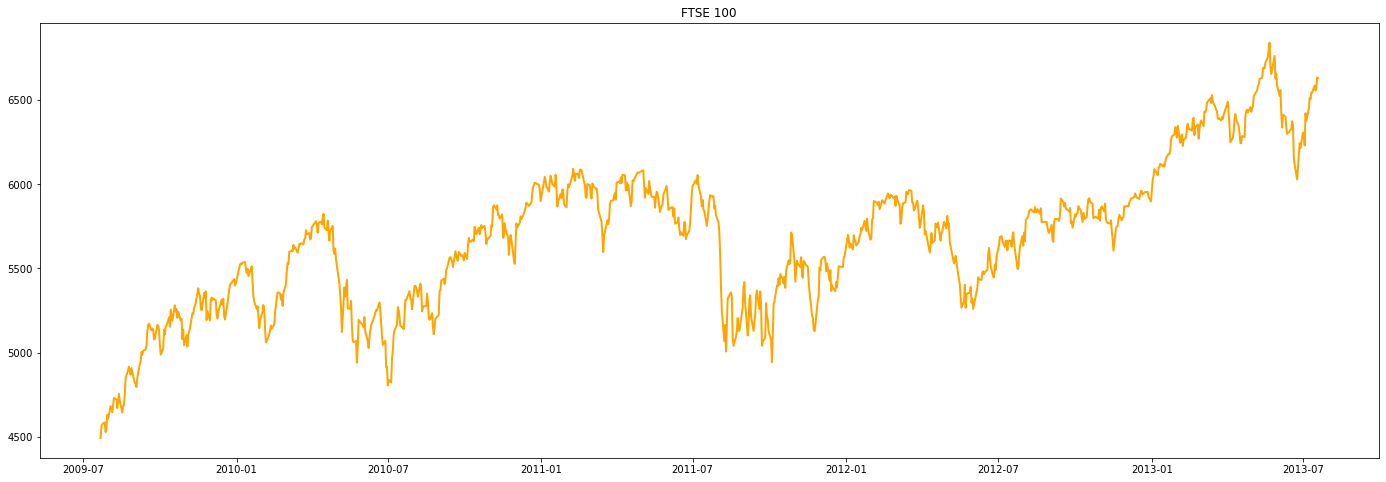

In [5]:
plt.plot(ftse, color='orange')
plt.title('FTSE 100')

In [6]:
ftse['Closing Price'][-200:].iplot()

In [7]:
#Calculating Daily Returns

returns = np.log(ftse['Closing Price']).diff()
returns = returns[~np.isnan(returns)]
returns[0:5]

Date
2009-07-23    0.014596
2009-07-24    0.003680
2009-07-27    0.002078
2009-07-28   -0.012571
2009-07-29    0.004118
Name: Closing Price, dtype: float64

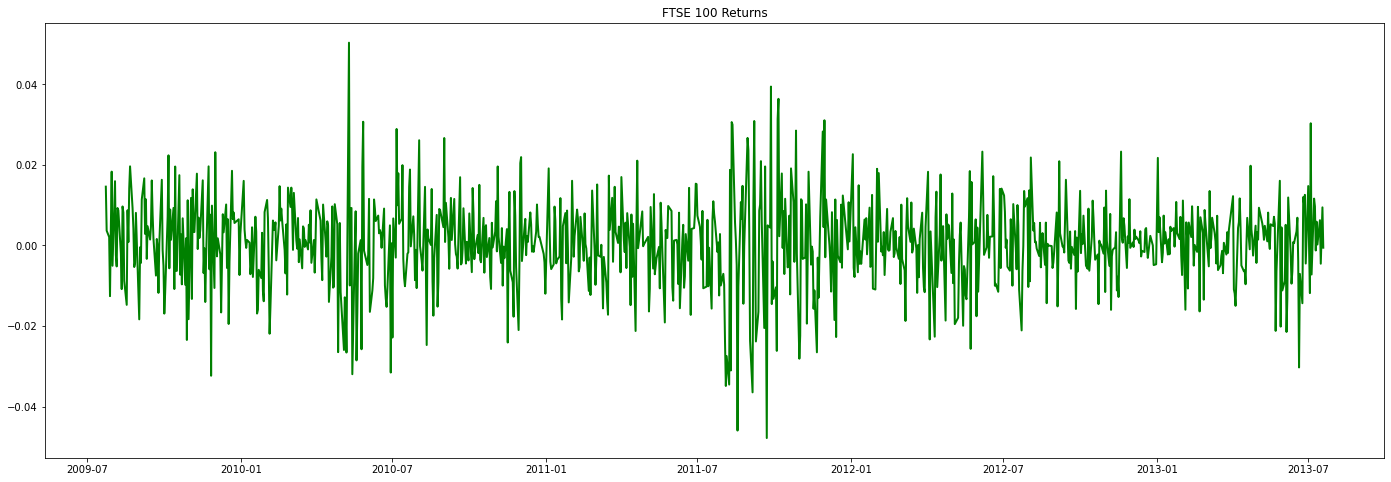

In [8]:
#Visualizing Daily Returns

plt.plot(returns, color='green')
plt.title('FTSE 100 Returns');

In [9]:
rolling21day_10dayvol = np.array(returns.rolling(21).std()*np.sqrt(10))


rolling21day_10dayvol = rolling21day_10dayvol[~np.isnan(rolling21day_10dayvol)]
rolling21day_10dayvol[:5]

array([0.03094887, 0.03209061, 0.03238809, 0.03238386, 0.03096461])

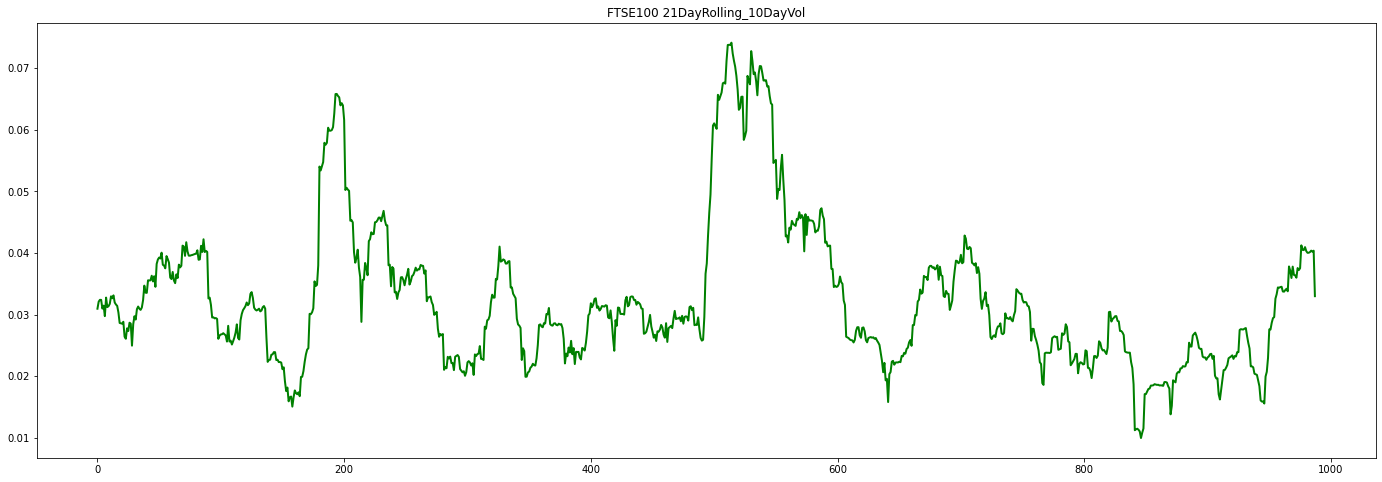

In [10]:
plt.plot(rolling21day_10dayvol, color='green')
plt.title('FTSE100 21DayRolling_10DayVol');

In [11]:
mean_ret_10day=returns.mean()*10
mean_ret_10day

0.003859352808010609

In [12]:
VaR_99_10day = norm.ppf(1-0.99,mean_ret_10day,rolling21day_10dayvol).flatten()[:,newaxis]
VaR_99_10day[:10]

array([[-0.06813848],
       [-0.07079458],
       [-0.07148662],
       [-0.07147676],
       [-0.0681751 ],
       [-0.06930316],
       [-0.065339  ],
       [-0.07234059],
       [-0.06875796],
       [-0.06909653]])

# C.2

Calculate the 99%/10day Value at Risk for an investment in the market index using a GARCH.

Assume a GARCH(1,1) model has been estimated from the long-term data as follows:

sigma**2 = 0.00001+0.047u(t-1)**2+0.9466sigma(t-1)**2

where omega=0.000001, alpha = 0.047, and beta = 0.9466

Apply the same time scaling rule and VaR formula as above. Set the initial value of sigma(0)**2 equal to the sample variance for all returns. Then, take past variance and return for t-1 from the row above to set up a recursive GARCH calculation as demonstrated in the Lecture.



In [13]:
omega=0.000001
alpha=0.047
beta=0.9466

In [14]:
def garch(omega, alpha, beta, returns):
    
    var=[]
    
    for i in range(ftse[1:].shape[0]):
        if i==0:
            var.append(np.var(returns))
        else:
            var.append(omega+alpha*returns[i-1]**2+beta*var[i-1])
            
    return np.array(var)
    

In [15]:
variance_GARCH = garch(omega, alpha, beta, returns).flatten()[:,newaxis]
variance_GARCH


array([[0.00011748],
       [0.00012222],
       [0.00011733],
       ...,
       [0.00012487],
       [0.00011947],
       [0.00011829]])

In [16]:
std_10day_garch=np.sqrt(variance_GARCH*10)
std_10day_garch

array([[0.03427476],
       [0.0349593 ],
       [0.03425279],
       ...,
       [0.03533759],
       [0.03456458],
       [0.03439369]])

In [17]:
plt.plot(std_10day_garch,color='red')
plt.title('GARCH Std Deviation (10day)');

In [18]:
VaR_99_GARCH_10day = norm.ppf(1-0.99,mean_ret_10day,std_10day_garch)
VaR_99_GARCH_10day[:10]

array([[-0.07587565],
       [-0.07746814],
       [-0.07582456],
       [-0.07408655],
       [-0.07492638],
       [-0.07342576],
       [-0.07714599],
       [-0.07570194],
       [-0.07795336],
       [-0.07616762]])

# C.3

Calculate the percentage VaR breaches for both measures, using 10-day period on the rolling basis. Are the breaches independent in time and independent of the level of VaR(volatility)?

Assume that a breach occurs when a realised 10-day index return meu(10D)=ln(s(t)/s(t-10)) is below the VaR quantity. The irsk measure assumed to be known and fixed at the start of each period.

Exmple: 20/08/2009 is the first day at which VaR computation is available, compare that figure to the index return realised in 10 days. Repeat. Total number of comparisions is N=978.

Hint: This is a computational problem. The question about VaR breaches being an iid process can be answered by a brief analysis of observations.


In [19]:

def realised_10day_ret(data_range,closeprice):
    
    realised_10day_return=[]
    
    for i in range(data_range):
        
        if i<=10:
            realised_10day_return.append(0)
        
        else:
            realised_10day_return.append(np.log(closeprice[i])-np.log(closeprice[i-10]))
        
    return realised_10day_return

In [20]:
realised_10day_return=realised_10day_ret(ftse.shape[0],ftse['Closing Price'])


In [21]:
df=pd.DataFrame({'Realised_10day_Return':realised_10day_return[21:],
                '99%10Day_VaR_Parametric':VaR_99_10day.flatten(),
                '99%10Day_VaR_GARCH':VaR_99_GARCH_10day[20:].flatten()},index = ftse.loc['2009-08-20':].index)

In [22]:
df

Realised_10day_Return  99%10Day_VaR_Parametric  99%10Day_VaR_GARCH
Date                                                                          
2009-08-20               0.013983                -0.068138           -0.071271
2009-08-21               0.024907                -0.070795           -0.073002
2009-08-24               0.036191                -0.071487           -0.077546
2009-08-25               0.051212                -0.071477           -0.077056
2009-08-26               0.036189                -0.068175           -0.075491
...                           ...                      ...                 ...
2013-07-15               0.043179                -0.089522           -0.081350
2013-07-16               0.039259                -0.090073           -0.079968
2013-07-17               0.053452                -0.089673           -0.078348
2013-07-18               0.032584                -0.090045           -0.076550
2013-07-19               0.039240                -0.072877           -0.076152

[988 rows x 3 columns]

In [23]:
df['VaR_99_Breach']= np.where(df['Realised_10day_Return'] < df['99%10Day_VaR_Parametric'], 1, 0)
df['VaR_99_GARCH_Breach']= np.where(df['Realised_10day_Return'] < df['99%10Day_VaR_GARCH'], 1, 0)

In [24]:
table=[['VaR_99',round(np.array(df['VaR_99_Breach'].value_counts(normalize=True)*100)[1],3)],
      ['VaR_99_GARCH',round(np.array(df['VaR_99_GARCH_Breach'].value_counts(normalize=True)*100)[1],3)]]

print(tabulate(table,headers=['VaR','% Breached']))

VaR             % Breached
------------  ------------
VaR_99               1.518
VaR_99_GARCH         1.215


In [25]:
# Testing if the breaches are independent in time and independent of the level of VaR (Volatility)


Text(0.5, 1.0, 'VaR Breaches - GARCH')

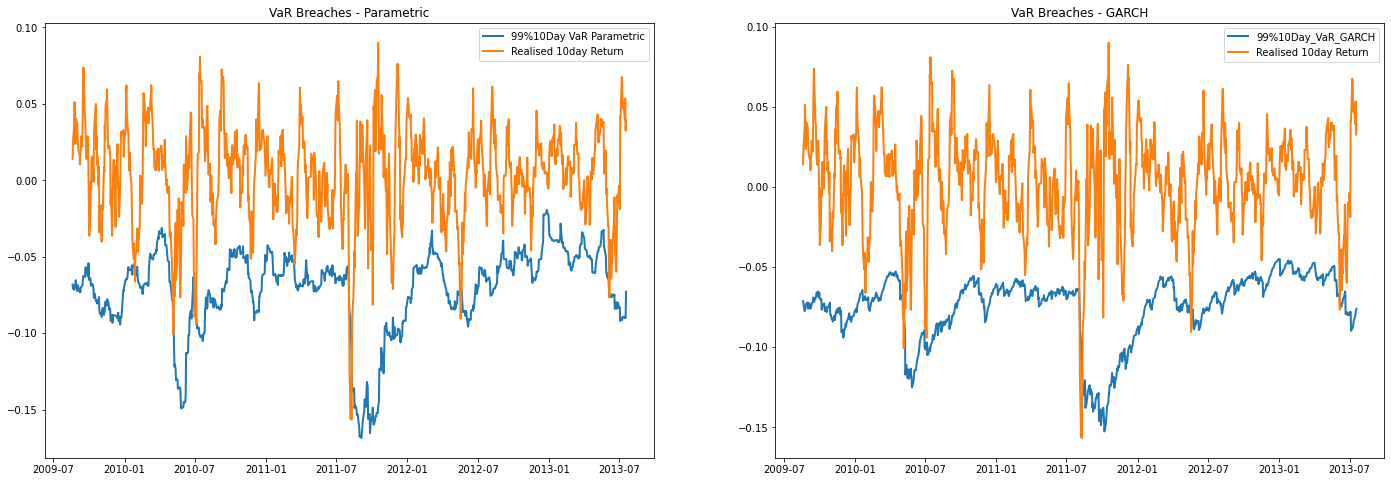

In [26]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)


ax1.plot(df['99%10Day_VaR_Parametric'],label='99%10Day VaR Parametric')
ax1.plot(df['Realised_10day_Return'],label='Realised 10day Return')
ax1.legend()
ax1.set_title('VaR Breaches - Parametric')

ax2.plot(df['99%10Day_VaR_GARCH'],label='99%10Day_VaR_GARCH')
ax2.plot(df['Realised_10day_Return'],label='Realised 10day Return')
ax2.legend()
ax2.set_title('VaR Breaches - GARCH')

In [27]:
y=df[['99%10Day_VaR_Parametric','99%10Day_VaR_GARCH']].describe()
print(tabulate(y, headers = y.columns))

         99%10Day_VaR_Parametric    99%10Day_VaR_GARCH
-----  -------------------------  --------------------
count                988                   988
mean                  -0.0716684            -0.0748168
std                    0.027582              0.0210041
min                   -0.16858              -0.152597
25%                   -0.0832252            -0.0806479
50%                   -0.0655258            -0.0692784
75%                   -0.0527962            -0.060752
max                   -0.0193154            -0.0449608


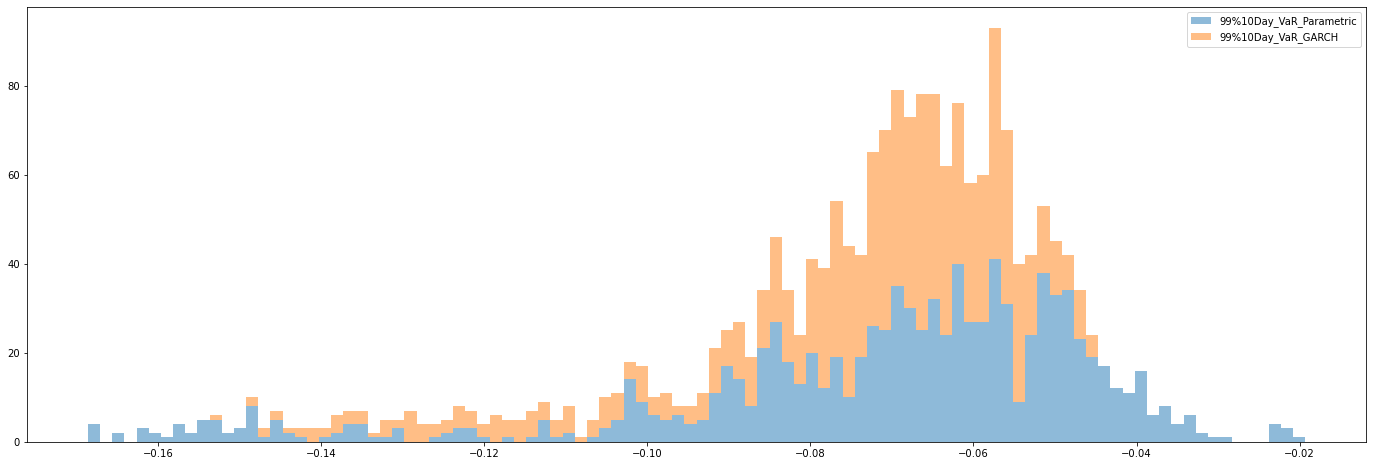

In [28]:
plt.hist(df[['99%10Day_VaR_Parametric','99%10Day_VaR_GARCH']],
         bins=100,
         stacked=True,
         label=['99%10Day_VaR_Parametric','99%10Day_VaR_GARCH'],
         alpha=0.5)

plt.legend(loc=0)


In [29]:
fig1 = px.ecdf(df[['99%10Day_VaR_Parametric','99%10Day_VaR_GARCH']])
fig1.show()

In [30]:
from scipy.stats import ks_2samp

In [31]:
ks_2samp(df['99%10Day_VaR_Parametric'],df['99%10Day_VaR_GARCH'])

KstestResult(statistic=0.19736842105263158, pvalue=3.053423700249712e-17)

In [32]:
from statsmodels.tsa.stattools import adfuller

In [33]:
adfuller(rolling21day_10dayvol)

(-2.493018927606886,
 0.11718214813189981,
 22,
 965,
 {'1%': -3.4371445907959832,
  '5%': -2.864539720789528,
  '10%': -2.5683672133480093},
 -9551.207774994931)

In [34]:
adfuller(std_10day_garch)

(-3.091136162541535,
 0.027216144241810826,
 21,
 986,
 {'1%': -3.4369994990319355,
  '5%': -2.8644757356011743,
  '10%': -2.5683331327427803},
 -10449.070361647739)